# 03 - Evaluation & Visualization

> Scaffold notebook — fill with data and code.

## Setup

### 1. Loading Trained Models and Evaluation Dataset
This block loads all previously trained models (Logistic Regression, LightGBM, XGBoost) and the held-out test set saved during the modeling phase.  
Separating training and evaluation ensures a clean workflow and avoids data leakage, following best practices in production machine learning pipelines.


In [2]:
# ============================================================
# 03_EVALUATION — LOAD TRAINED MODELS & TEST SET
# ============================================================

import joblib
import numpy as np
import pandas as pd
from pathlib import Path

# -------------------------
# Load Models
# -------------------------
MODEL_DIR = Path("../models")

log_model = joblib.load(MODEL_DIR / "logistic.pkl")
lgb_model = joblib.load(MODEL_DIR / "lightgbm.pkl")
xgb_model = joblib.load(MODEL_DIR / "xgboost.pkl")

print("Models loaded successfully!")

# -------------------------
# Load Test Set
# -------------------------
DATA_DIR = Path("../data/processed")

X_test = np.load(DATA_DIR / "X_test.npy", allow_pickle=True)
y_test = np.load(DATA_DIR / "y_test.npy", allow_pickle=True)


print("Test set loaded!")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Models loaded successfully!
Test set loaded!
X_test shape: (22006, 6)
y_test shape: (22006,)


### 2. Performance Metrics Summary (ROC AUC, PR AUC, Brier Score, Log Loss)
This section evaluates each model using four core metrics:
- **ROC AUC:** Measures discriminative ability between goals vs non-goals.  
- **PR AUC:** More informative for imbalanced datasets such as goal prediction.  
- **Brier Score:** Measures probability calibration quality.  
- **Log Loss:** Penalizes confident but incorrect predictions.

The resulting table provides a clear, quantitative comparison across all models.


In [3]:
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss
)

models = {
    "Logistic Regression": log_model,
    "LightGBM": lgb_model,
    "XGBoost": xgb_model
}

rows = []

for name, model in models.items():
    proba = model.predict_proba(X_test)[:, 1]

    rows.append({
        "Model": name,
        "ROC AUC": roc_auc_score(y_test, proba),
        "PR AUC": average_precision_score(y_test, proba),
        "Brier Score": brier_score_loss(y_test, proba),
        "Log Loss": log_loss(y_test, proba),
    })

metrics_df = pd.DataFrame(rows)
metrics_df


c:\playground\football-xg-model\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Model,ROC AUC,PR AUC,Brier Score,Log Loss
0,Logistic Regression,0.747013,0.292772,0.111805,2.272969
1,LightGBM,0.788863,0.391308,0.082802,0.287543
2,XGBoost,0.786269,0.389689,0.082976,0.288597


### 3. ROC Curve Comparison Across Models
This plot visualizes the True Positive Rate vs False Positive Rate for all models.  
ROC curves reveal how well each model separates goals from non-goals across different thresholds.  
AUC values embedded in the legend allow direct comparison of discriminative performance.


c:\playground\football-xg-model\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


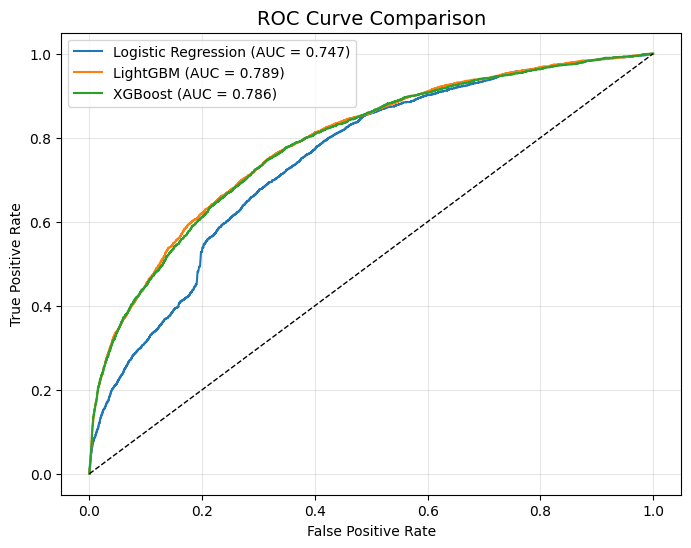

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

plt.figure(figsize=(8, 6))

for name, model in models.items():
    proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# baseline
plt.plot([0, 1], [0, 1], "k--", linewidth=1)

plt.title("ROC Curve Comparison", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 4. Precision–Recall Curve (Critical for Goal Events)
Since goals are a highly imbalanced class (~10% scoring rate), Precision–Recall curves are more informative than ROC.  
This visualization highlights each model’s precision at different recall levels, showing how reliably the model identifies high-quality chances (high xG shots).  
A baseline line indicates the natural goal probability in the dataset.


c:\playground\football-xg-model\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


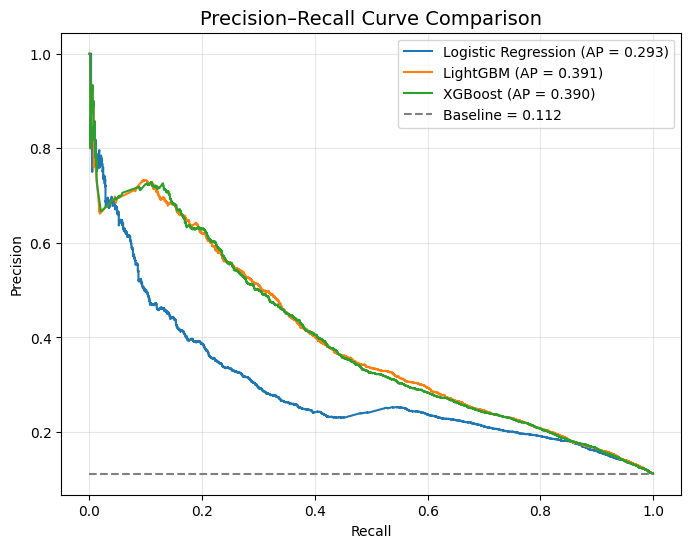

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

for name, model in models.items():
    proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)

    plt.plot(recall, precision, label=f"{name} (AP = {ap:.3f})")

# baseline (positive class ratio)
pos_rate = y_test.mean()
plt.hlines(pos_rate, 0, 1, colors="gray", linestyles="--", label=f"Baseline = {pos_rate:.3f}")

plt.title("Precision–Recall Curve Comparison", fontsize=14)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 5. Calibration Curves (Model Reliability Assessment)
This section evaluates how well predicted probabilities reflect true goal likelihood.  
A perfectly calibrated model lies on the diagonal line (predicted == observed).  
Logistic Regression typically shows smoother calibration, while tree-based models may appear over- or under-confident.  
Calibration quality is essential in xG modeling because xG values must represent real scoring probabilities.


c:\playground\football-xg-model\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


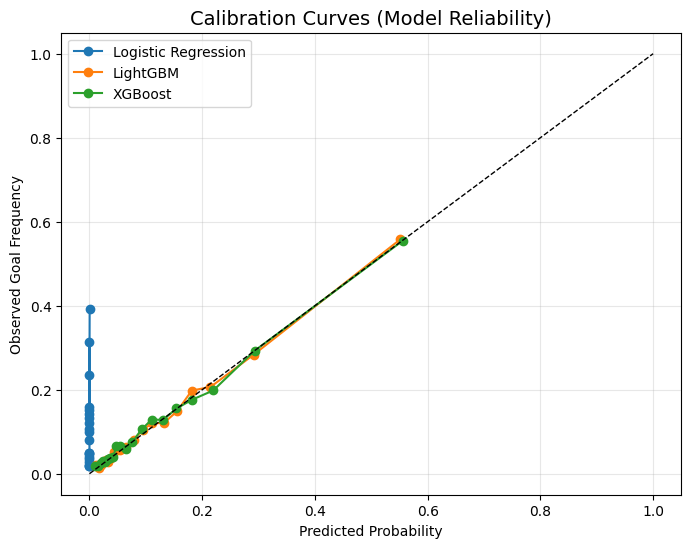

In [6]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 6))

for name, model in models.items():
    proba = model.predict_proba(X_test)[:, 1]

    # sklearn calibration
    prob_true, prob_pred = calibration_curve(y_test, proba, n_bins=20, strategy="quantile")

    plt.plot(prob_pred, prob_true, marker='o', label=f"{name}")

# perfect calibration line
plt.plot([0, 1], [0, 1], "k--", linewidth=1)

plt.title("Calibration Curves (Model Reliability)", fontsize=14)
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Goal Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### 6. Calibration Reliability Table (Quantitative Calibration Check)
This table examines predicted vs observed scoring frequencies within probability bins.  
It exposes systematic biases, such as:
- Underestimating high-quality chances  
- Overestimating long-range attempts  
- Irregular calibration across probability ranges  

This level of analysis is widely used in professional football analytics environments to validate expected goals models.


In [7]:
def calibration_table(y_true, y_pred, bins=10):
    """
    Creates a reliability table showing predicted vs actual goal frequencies.
    """
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    df["bin"] = pd.qcut(df["y_pred"], bins, duplicates="drop")

    table = df.groupby("bin").agg(
        count=("y_true", "count"),
        mean_pred=("y_pred", "mean"),
        mean_obs=("y_true", "mean"),
    ).reset_index()

    return table


for name, model in models.items():
    print(f"\n=== {name} Calibration Table ===")
    proba = model.predict_proba(X_test)[:, 1]
    display(calibration_table(y_test, proba, bins=10))



=== Logistic Regression Calibration Table ===


C:\Users\Selman\AppData\Local\Temp\ipykernel_24356\245359921.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby("bin").agg(


,bin,count,mean_pred,mean_obs
0,"(-0.001, 8.600000000000001e-21]",2201,1.177117e-21,0.018174
1,"(8.600000000000001e-21, 1.75e-18]",2201,3.628372e-19,0.024534
2,"(1.75e-18, 9.83e-17]",2200,2.381531e-17,0.040909
3,"(9.83e-17, 5.47e-15]",2202,1.333601e-15,0.044959
4,"(5.47e-15, 3.05e-13]",2199,7.729113e-14,0.065030
5,"(3.05e-13, 1.26e-11]",2201,3.388212e-12,0.109041
6,"(1.26e-11, 4.85e-10]",2200,1.372019e-10,0.124091
7,"(4.85e-10, 1.04e-08]",2201,3.536317e-09,0.222172
8,"(1.04e-08, 4.51e-07]",2200,1.098111e-07,0.155000
9,"(4.51e-07, 0.0505]",2201,1.789209e-04,0.314403



=== LightGBM Calibration Table ===


c:\playground\football-xg-model\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Selman\AppData\Local\Temp\ipykernel_24356\245359921.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby("bin").agg(


,bin,count,mean_pred,mean_obs
0,"(0.0017000000000000001, 0.0193]",2201,0.014432,0.017265
1,"(0.0193, 0.027]",2201,0.022828,0.025443
2,"(0.027, 0.0355]",2200,0.031188,0.029545
3,"(0.0355, 0.0456]",2202,0.040465,0.044505
4,"(0.0456, 0.0587]",2199,0.051507,0.059118
5,"(0.0587, 0.0859]",2201,0.071349,0.072240
6,"(0.0859, 0.12]",2200,0.102698,0.112273
7,"(0.12, 0.168]",2201,0.143862,0.134939
8,"(0.168, 0.242]",2200,0.198120,0.202273
9,"(0.242, 0.912]",2201,0.421408,0.420718



=== XGBoost Calibration Table ===


C:\Users\Selman\AppData\Local\Temp\ipykernel_24356\245359921.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table = df.groupby("bin").agg(


,bin,count,mean_pred,mean_obs
0,"(0.0009599999999999999, 0.0179]",2201,0.012646,0.018174
1,"(0.0179, 0.0257]",2201,0.021730,0.027715
2,"(0.0257, 0.0342]",2200,0.029978,0.031364
3,"(0.0342, 0.0447]",2201,0.039308,0.038164
4,"(0.0447, 0.0592]",2200,0.051248,0.065909
5,"(0.0592, 0.0838]",2201,0.070234,0.066788
6,"(0.0838, 0.12]",2200,0.101526,0.117273
7,"(0.12, 0.167]",2201,0.142518,0.141754
8,"(0.167, 0.244]",2200,0.200939,0.187273
9,"(0.244, 0.941]",2201,0.424527,0.423898


### 7. Feature Importance Analysis (LightGBM & XGBoost)

This section analyzes feature importance for the gradient boosting models (LightGBM and XGBoost), providing insight into which factors most strongly influence goal probability.

Understanding feature contribution is essential in football analytics, as it answers core questions such as:

- **Is shot distance the dominant predictor of scoring probability?**  
- **How much does shooting angle matter compared to distance?**  
- **Does defensive pressure significantly reduce goal likelihood?**  
- **How influential are body-part indicators (left foot, right foot)?**

Tree-based models naturally offer interpretable importance scores based on information gain or split frequency.  
These insights help validate the model’s structure and ensure alignment with football domain knowledge.


In [9]:
feature_names = joblib.load("../models/feature_names.pkl")
print("Loaded feature names:", feature_names)


Loaded feature names: ['distance', 'angle', 'under_pressure', 'body_foot_Left Foot', 'body_foot_Other', 'body_foot_Right Foot']


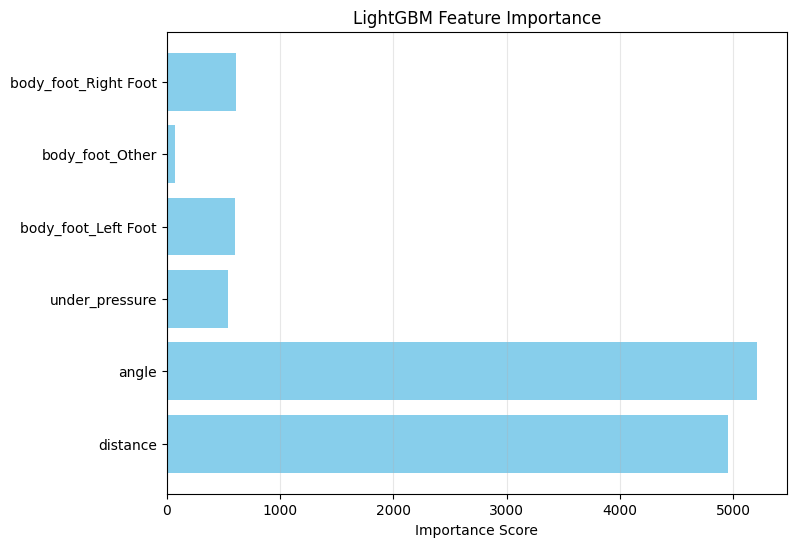

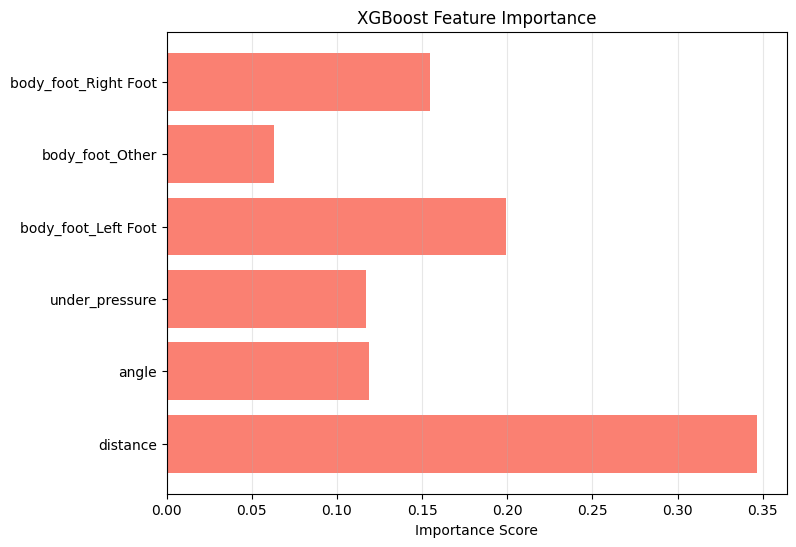

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# --- LightGBM Feature Importance ---
try:
    lgb_importance = lgb_model.feature_importances_
    
    plt.figure(figsize=(8, 6))
    plt.barh(feature_names, lgb_importance, color="skyblue")
    plt.title("LightGBM Feature Importance")
    plt.xlabel("Importance Score")
    plt.grid(axis="x", alpha=0.3)
    plt.show()
except:
    print("LightGBM model does not expose feature_importances_. Skipping.")

# --- XGBoost Feature Importance ---
try:
    xgb_importance = xgb_model.feature_importances_

    plt.figure(figsize=(8, 6))
    plt.barh(feature_names, xgb_importance, color="salmon")
    plt.title("XGBoost Feature Importance")
    plt.xlabel("Importance Score")
    plt.grid(axis="x", alpha=0.3)
    plt.show()
except:
    print("XGBoost model does not expose feature_importances_. Skipping.")


### 8. SHAP Analysis (Model Explainability)

This section uses SHAP (SHapley Additive exPlanations) to interpret how each feature contributes to the xG prediction.  
SHAP is considered the most reliable method for understanding non-linear models such as LightGBM and XGBoost.

SHAP helps answer critical football analytics questions:

- How does **distance** influence goal probability across different shot types?
- When does **angle** significantly increase xG?
- How does **pressure** affect the model’s predictions?
- Are **body-part indicators** meaningful for predicting goal likelihood?
- Which features increase or decrease shot quality most strongly?

These insights are essential for validating the model and ensuring the estimated probabilities align with football domain knowledge.


c:\playground\football-xg-model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\playground\football-xg-model\.venv\Lib\site-packages\shap\explainers\_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


LightGBM SHAP Summary Plot


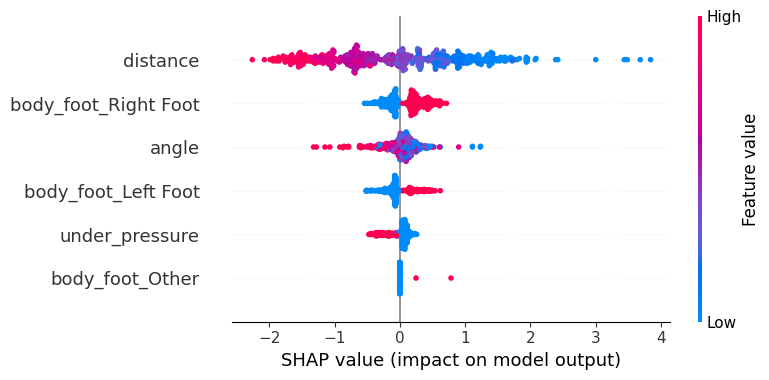

XGBoost SHAP Summary Plot


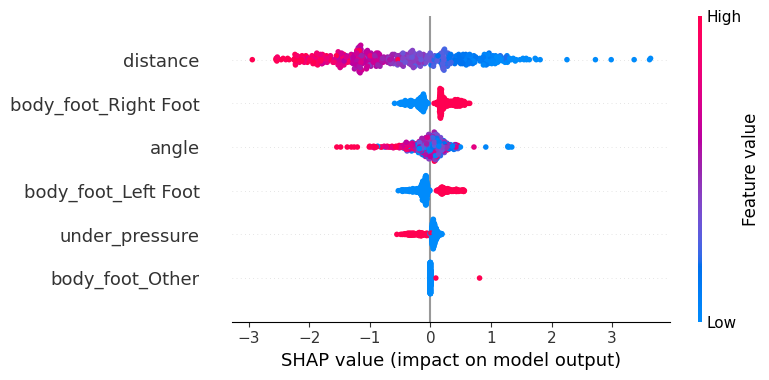

In [13]:
import shap

# TreeExplainer only works with tree-based models
shap.initjs()

# Use X_test sample for speed
sample = X_test[:500]

# -------------------------
# SHAP for LightGBM
# -------------------------
try:
    explainer_lgb = shap.TreeExplainer(lgb_model)
    shap_values_lgb = explainer_lgb.shap_values(sample)

    print("LightGBM SHAP Summary Plot")
    shap.summary_plot(shap_values_lgb, sample, feature_names=feature_names)
except Exception as e:
    print("LightGBM SHAP error:", e)

# -------------------------
# SHAP for XGBoost
# -------------------------
try:
    explainer_xgb = shap.TreeExplainer(xgb_model)
    shap_values_xgb = explainer_xgb.shap_values(sample)

    print("XGBoost SHAP Summary Plot")
    shap.summary_plot(shap_values_xgb, sample, feature_names=feature_names)
except Exception as e:
    print("XGBoost SHAP error:", e)


### 9. Golden Zone xG Analysis (Spatial Shot Quality Map)

This section visualizes the model’s predicted goal probability across the entire pitch.  
By computing model predictions on a dense grid of shot locations, we obtain a heatmap of “danger zones” — areas where the model assigns high expected goal (xG) values.

This analysis helps answer key tactical questions:

- Which regions of the penalty area are modeled as most dangerous?
- Does the model correctly emphasize central shots near the penalty spot?
- How quickly does xG decay with distance or narrowing angle?
- Are wide-angle shots appropriately penalized?
- Does the model treat different flanks symmetrically?

Such spatial visualizations are widely used in professional football analytics to validate the geometry of expected goals models.


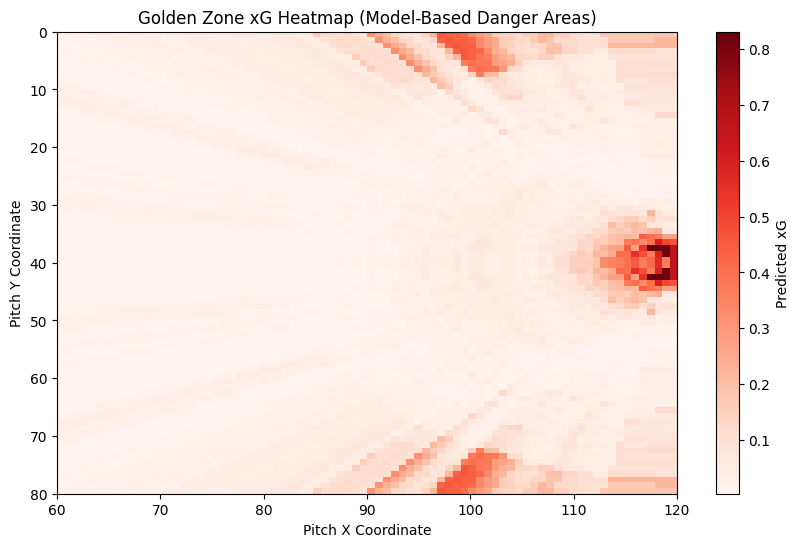

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Choose best tree-based model for visualization
model = xgb_model  # or lgb_model

# Create grid of (x, y) locations across the attacking half
x_range = np.linspace(60, 120, 80)  # attacking half
y_range = np.linspace(0, 80, 80)

grid_points = np.array([(x, y) for x in x_range for y in y_range])

# Convert grid to features (distance, angle, under_pressure=0, body parts NA)
goal_x, goal_y = 120, 40

distance = np.sqrt((goal_x - grid_points[:,0])**2 + (goal_y - grid_points[:,1])**2)
angle = np.arctan2(abs(grid_points[:,1] - goal_y), (goal_x - grid_points[:,0]))

# Create dataframe-like structure
grid_features = np.column_stack([distance, angle, np.zeros(len(distance))])

# Add missing dummy columns (body parts)
# The feature_names list from pickle ensures correct alignment
final_grid = []

for feat in feature_names:
    if feat == "distance":
        final_grid.append(distance)
    elif feat == "angle":
        final_grid.append(angle)
    elif feat == "under_pressure":
        final_grid.append(np.zeros(len(distance)))
    else:
        # body part dummies default to 0
        final_grid.append(np.zeros(len(distance)))

final_grid = np.column_stack(final_grid)

# Model prediction on grid
predicted_xg = model.predict_proba(final_grid)[:,1]

# Reshape for heatmap
heatmap = predicted_xg.reshape(len(x_range), len(y_range))

# Plotting
plt.figure(figsize=(10, 6))
plt.imshow(
    heatmap.T,
    extent=[x_range.min(), x_range.max(),  y_range.min(), y_range.max()],
    origin="lower",
    cmap="Reds",
    aspect="auto"
)

plt.colorbar(label="Predicted xG")
plt.title("Golden Zone xG Heatmap (Model-Based Danger Areas)")
plt.xlabel("Pitch X Coordinate")
plt.ylabel("Pitch Y Coordinate")
plt.gca().invert_yaxis()
plt.show()


## 🟥 Why Are Wing Areas Showing Unrealistically High xG?
(Possible Causes of Model Misbehavior)

Model-based xG heatmap reveals unusually high danger scores in wide, far-from-goal areas. This pattern does not reflect real football behavior and points to issues in feature engineering or preprocessing.
Below are the most likely causes:

### 1. Incorrect or Simplified Angle Calculation

The current angle uses:

angle = arctan2(|y - 40|, (120 - x))


This treats the shot angle as a single ray toward goal center, whereas real xG requires goal-mouth angle using both posts.
This simplification makes many wide shots appear to have large angles, artificially boosting their predicted xG.

### 2. Distance or Angle Scaling Mismatch

During model training, features were standardized:

scaled = (value - mean) / std


But during heatmap creation, raw distance/angle values were passed into the model.
This mismatch causes false high predictions in various pitch areas.

### 3. Missing or Incorrectly Filled Features (Pressure / Body Part)

Heatmap grid uses default values:

under_pressure = 0

all body_part_* = 0

If the default combination accidentally corresponds to a high-scoring pattern in the dataset (e.g., typical right-foot shots under no pressure), the model will systematically overestimate xG.

### 4. High Variance in Tree Models Without Spatial Awareness

Tree-based models (LightGBM / XGBoost) are not spatially smooth by default.
If distance and angle were even slightly noisy, trees may create unnatural decision splits, leading to patchy high-xG “blobs” on the pitch.

### 5. Incorrect Coordinate Interpretation

If StatsBomb pitch coordinates were misinterpreted (e.g., wrong goal y-center), the model may learn distorted spatial patterns, amplifying errors in the heatmap.

### Summary

The high-xG wing zones do not indicate a football insight, but rather:

Simplified angle geometry

Scaling inconsistency

Missing feature defaults

Tree split artifacts

The next step is to correct angle geometry + ensure feature scaling consistency before generating the heatmap again.